<div>
<a href="http://www.music-processing.de/"><img style="float:left;" src="../data/FMP_Teaser_Cover.png" width=40% alt="FMP"></a>
<a href="https://www.audiolabs-erlangen.de"><img src="../data/Logo_AudioLabs_Long.png" width=59% style="float: right;" alt="AudioLabs"></a>
</div>

<div> 
<div style="float:right;"><a href="../B/B.html"><img src="../data/B_nav.png" width="100" style="float:right;" alt="B"></a></div>
<div ><h1>Python Visualization</h1> </div>
</div>

<p>   
Python provides powerful functionalities for generating and plotting figures. Rather than being comprehensive, we discuss in this notebook some concrete examples on how to generate images to visualize waveforms (audio signals), spectrograms (time&ndash;frequency representations), and other feature representations. Doing so, we introduce alternatives based on the  Python library <a href="https://matplotlib.org">Matplotlib</a> and the Python package <a href="https://librosa.org/doc">LibROSA</a>. After a general introduction, we cover the following topics:    
    
<ul>    
<li> Plotting a waveform with physical time axis (given in seconds)</li>
<li> Plotting a spectrogram with physical time axis (given in seconds) and frequency axis (given in Hertz)</li>
<li> Plotting a chromagram (time&ndash;chroma representation)</li>
<li> Controlling the size of the colorbar (using <code>gridspec</code>)</li>
<li> Defining useful colormaps (with logarithmic color distribution)</li>
</ul>
</p>

## Python Packages for Visualization

The library `matplotlib` is a widely used Python package for creating visualizations, allowing a user to produce high-quality figures in a variety of formats as well as interactive environments across platforms. The [main website](https://matplotlib.org/) contains a detailed documentation and links to illustrative code examples.  In particular, we recommend to have a look at the [gallery](https://matplotlib.org/gallery/index.html), which contains numerous examples of the many things you can do with `matplotlib`. In particular, we will use [`matplotlib.pyplot`](https://matplotlib.org/api/pyplot_api.html), which is a collection of command style functions that make matplotlib work similar to MATLAB. Following general conventions, we use the following abbreviation:

`import matplotlib.pyplot as plt`

[LibROSA](https://librosa.org/doc) is a Python package specifically desigend for music and audio analysis. While providing various building blocks necessary to create music information retrieval systems, LibROSA also contains a number of specialized visualization functions contained in [`librosa.display`](https://librosa.org/doc/latest/display.html). These functions, in turn, build on the library `matplotlib`. Using functions from LibROSA is often convenient, since they provide default settings and presets that have turned out to be meaningful in music processing scenarios. However, if not changed explicitly, these presets are applied automatically, which may lead to inconsistencies and unexpected effects.

<div class="alert alert-block alert-warning">
<strong>Note:</strong>
When applying high-level visualization functions, it is important to understand the default settings and presets by looking into the source code!
</div>

## Some Basic Examples

We start with some basic examples that show how the library `matplotlib` works. First, we import various Python packages required in this notebook. The command `%matplotlib inline` ensures that the backend of `matplotlib` is set to `inline` so that figures are displayed within the Jupyter notebook. We then generate a sine and cosine function, which are plotted in the same figure. The axes are modified and labeled. Finally, the figure is exported in the `PNG` format.

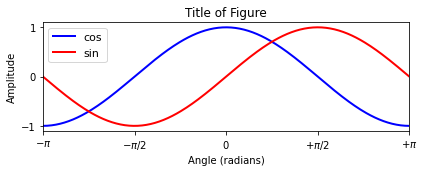

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import librosa
import librosa.display
%matplotlib inline

plt.figure(figsize=(6, 2.5))
plt.title('Title of Figure', fontsize=12)
X = np.linspace(-np.pi, np.pi, 256, endpoint=True)
C, S = np.cos(X), np.sin(X)
plt.plot(X, C, color='blue', linewidth=2.0, linestyle='-', label='cos')
plt.plot(X, S, color='red', linewidth=2.0, linestyle='-', label='sin')
plt.legend(loc='upper left', fontsize=11)
plt.xlim(-np.pi, np.pi)
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
           [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$+\pi/2$', r'$+\pi$'], fontsize=10)
plt.ylim(C.min() * 1.1, C.max() * 1.1)
plt.yticks([-1, 0, 1], fontsize=10)
plt.xlabel('Angle (radians)')
plt.ylabel('Amplitude')
plt.tight_layout()

# This requires that the output folder exists
output_path_filename = os.path.join('..', 'output', 'B', 'FMP_B_Figure_CosSin.png')
plt.savefig(output_path_filename)

The next example demonstrates how to create subplots using [`subplot` ](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) and [`axes` ](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.axes.html) as well as different features of `matplotlib`. The command [`tight_layout()`](https://matplotlib.org/users/tight_layout_guide.html) automatically adjust subplot parameters. However, this is an experimental feature and may not work for some cases. 

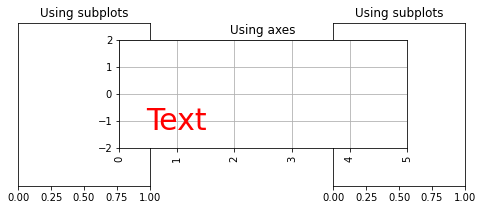

In [2]:
plt.figure(figsize=(8, 3))

plt.subplot(1, 3, 1)
plt.yticks(())
plt.title('Using subplots', fontsize=12)
plt.subplot(1, 3, 3)
plt.yticks(())
plt.title('Using subplots', fontsize=12)
plt.axes([0.3, 0.3, 0.5, 0.5])    # [left, bottom, width, height]
plt.title('Using axes', fontsize=12)
plt.xlim(0, 5)
plt.ylim(-2, 2)
plt.grid()
ax = plt.gca()
plt.setp(ax.get_xticklabels(), rotation='vertical', fontsize=10)
plt.text(1, -1, 'Text', ha='center', va='center', size=30, color='red')

output_path_filename = os.path.join('..', 'output', 'B', 'FMP_B_Figure_Subplots.png')
plt.savefig(output_path_filename)

Next, we illustrate how to visualize the graph of a function generated by Python. In the following example, we use the notation and the concepts introduced in Chapter 2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>. 

* We first generate a discrete-time signal $x$ using the sampling rate $F_\mathrm{s}=256$. 
* The we compute the [discrete Fourier transform](../C2/C2_DFT-FFT.html) (DFT) $X$ of the signal by applying an [FFT](../C2/C2_DFT-FFT.html). 
* The complex-valued DFT $X$ is modified by setting all values which magnitudes are below a certain threshold $\tau$ to zero. This results in $X_\mathrm{mod}$.
* Finally, the [inverse DFT](../C2/C2_STFT-Inverse.html) is applied to reconstruct a time domain signal. We define $x_\mathrm{mod}$ to be the real part of this signal.

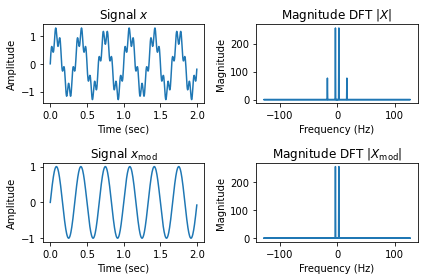

In [3]:
import numpy as np

Fs = 256
duration = 2
num_samples = int(Fs * duration)
t = np.arange(num_samples) / Fs
x = np.sin(2 * np.pi * 3 * t) + 0.3 * np.sin(2 * np.pi * 17 * t)
plt.figure(figsize=(6, 4))
plt.subplot(2, 2, 1)
plt.plot(t, x) 
plt.title('Signal $x$')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')

X = np.fft.fft(x)
freq = np.fft.fftfreq(x.size, d=1/Fs)
plt.subplot(2, 2, 2)
plt.plot(freq, np.abs(X))
plt.title('Magnitude DFT $|X|$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude') 

tau = 100
X_mod = X.copy()
X_mod[np.abs(X) < tau] = 0
plt.subplot(2, 2, 4)
plt.plot(freq, np.abs(X_mod))
plt.title('Magnitude DFT $|X_\mathrm{mod}|$')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

x_mod = np.real(np.fft.ifft(X_mod))
plt.subplot(2, 2, 3)
plt.plot(t, x_mod)
plt.title('Signal $x_\mathrm{mod}$')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.tight_layout()

output_path_filename = os.path.join('..', 'output', 'B', 'FMP_B_Figure_DFT.png')
plt.savefig(output_path_filename)

## Plotting a Waveform

For the next plots, we use an audio recording of a $\mathrm{C}$-major scale played on a piano as an illustrating example. For an introduction to [audio representations and waveforms](../C1/C1S3_Waveform.html), we refer to Section 1.3 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015].</a>

<img src="../data/B/FMP_B_Scale-Cmajor.png" width="300px" alt="C-major scale" align="left">  

<br clear="all" />

<audio src="../data/B/FMP_B_Scale-Cmajor_Piano.wav" type="audio/mpeg" controls="controls"></audio>
   
First, we load the audio file converting the sampling rate to `Fs=11025` Hertz.

In [4]:
Fs = 11025
x, Fs = librosa.load(os.path.join('..', 'data', 'B', 'FMP_B_Scale-Cmajor_Piano.wav'), sr=Fs)
print('The signal x has %d samples and a duration of %.2f seconds.' % (len(x), len(x) / Fs))

The signal x has 120400 samples and a duration of 10.92 seconds.


Next, we plot the waveform of the signal. Mathematically, the signal x is simply an ordered sequence of real numbers. The indices are interpreted as time and the numbers as sampled amplitude values. To convert indices to physical time positions, one needs to know the sampling rate. The following code shows how to plot the signal using Matplotlib's [`plot` function](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html). Furthermore, we illustrate how one may further manipulate the figures (e.g., labels, axes, limits, and so on).

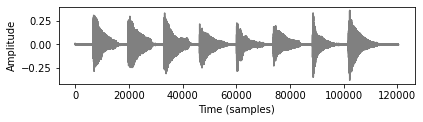

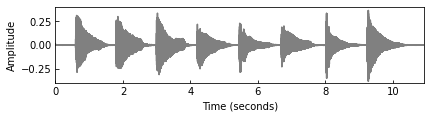

In [5]:
plt.figure(figsize=(6, 1.8))
plt.plot(x, color='gray')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.tight_layout()

# Define time axis in seconds
t = np.arange(x.shape[0]) / Fs
plt.figure(figsize=(6, 1.8))
plt.plot(t, x, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.xlim([t[0], t[-1]])
plt.ylim([-0.40, 0.40])
plt.tick_params(direction='in')
plt.tight_layout()

As an alternative, one can use the function `librosa.display.waveplot`, which has a number of convenient presets. Note that, rather than plotting the samples, this function plots a **(filled) amplitude envelope of a waveform**, which results in a plot symmetric with respect to the horizontal axis. This becomes evident when comparing the following plot with the previous plot.

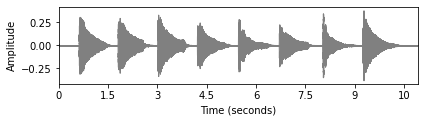

In [6]:
plt.figure(figsize=(6, 1.8))
librosa.display.waveplot(x, sr=Fs, color='gray')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()

## Plotting a Spectrogram

The waveform of a signal yields an example for a one-dimensional plot. Very often, one has to deal with representations that depend on several parameters, thus requiring plots of high-dimensional data points. In the following, we consider the case of 2D-plots using spectrogram representations as an example. Intuitively, a [spectrogram](../C2/C2_STFT-Basic.html) is a time–frequency representation of a signal, which indicates the intensity of occurring frequencies over time. A (magnitude) spectrogram can be obtained by computing a [short-time Fourier transform](../C2/C2_STFT-Basic.html) (STFT) of a signal and then taking the magnitude values of each Fourier coefficient. For details, we refer to Section 2.1.4 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

In the following code example, we compute an STFT using the `librosa` package based a window size $N$ and hop size $H$. (As default setting, a Hann window is used with frames being centered using symmetric padding.) Furthermore, we use the function `librosa.display.specshow` to visualize the spectrogram $Y$, where the magnitude values are converted to a decibel scale and plotted in a color-coded form. Note that the time and frequency axis have been automatically converted to physical units given in seconds and Hertz, respectively.

Shape of spectrogram: (1025, 118)


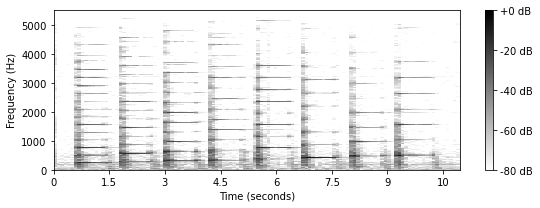

In [7]:
N, H = 2048, 1024

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
Y = np.abs(X)
print('Shape of spectrogram:', Y.shape)

plt.figure(figsize=(8, 3))
librosa.display.specshow(librosa.amplitude_to_db(Y, ref=np.max), 
                         y_axis='linear', x_axis='time', sr=Fs, hop_length=H, cmap='gray_r')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()

It is often not straightforward how to relate physical properties (e.g., time given in seconds) with discretized versions (e.g., time given in frames). One reason is that, for example, a frame index corresponds to an entire temporal range (covered by the window function) rather than a single time point. We often follow a [**centered view**](../C2/C2_STFT-Conventions.html), where the center of the first frame corresponds to the time point $0$ (given in seconds). Therefore, when computing for example an STFT frame, one needs to apply suitable [padding techniques](../C2/C2_STFT-Padding.html) (extending the signal by half the window length to the left). Note that different padding conventions may lead to different results.

Knowing the the sampling rate `Fs`, the window size `N` and the hop size `H`, one can compute for each spectral coefficient `Y[k, n]` the physical time position (in seconds) corresponding to frame index `n` and physical frequency value (in Hertz)  corresponding to bin index `k`. This is done internally by the function `librosa.display.specshow` when plotting physical units given in seconds and Hertz. 

Using the centered convention, the following code shows how to compute time values corresponding to frame indices as well as frequency values corresponding to bin indices. These conversions can also be done using `librosa`-functions as demonstrated below:

In [8]:
t_samples = np.arange(x.shape[0]) / Fs
t_frames = np.arange(X.shape[1]) * H / Fs
f_hertz = np.arange(N / 2 + 1) * Fs / N       # Works only when N is even
# f_hertz = np.fft.rfftfreq(N, 1 / Fs)         # Works also when N is odd

print('Time (seconds) of last sample:', t_samples[-1])
print('Time (seconds) of last frame: ', t_frames[-1])
print('Frequency (Hz) of last bin:   ', f_hertz[-1])

t_samples_librosa = librosa.samples_to_time(np.arange(x.shape[0]), sr=Fs)
t_frames_librosa = librosa.frames_to_time(np.arange(X.shape[1]), sr=Fs, hop_length=H)
f_hertz_librosa = librosa.fft_frequencies(Fs, N)

assert np.all(t_samples == t_samples_librosa)
assert np.all(t_frames == t_frames_librosa)
assert np.all(f_hertz == f_hertz_librosa)

Time (seconds) of last sample: 10.920544217687075
Time (seconds) of last frame:  10.866938775510205
Frequency (Hz) of last bin:    5512.5


In general, one can use the function `matplotlib.pyplot.imshow` to plot two-dimensional real-valued arrays as images. The following code plots the array $Y$, where the first axis corresponds to frequency (bins) and the second axis to time (samples).

The spectrogram Y has 1025 frequency bins and 118 frames.


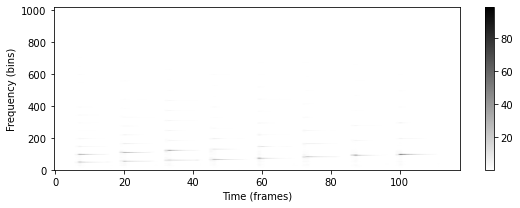

In [9]:
print('The spectrogram Y has %d frequency bins and %d frames.' % (Y.shape[0], Y.shape[1]))
plt.figure(figsize=(8, 3))
plt.imshow(Y, cmap='gray_r', aspect='auto', origin='lower')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (bins)')
plt.colorbar()
plt.tight_layout()

As can be seen in the previous figure, the image is positioned such that the pixel centers fall on zero-based (row, column) indices. To have tick labels with physical meaning, one can use the `extent` keyword argument to specify the data coordinates `[left, right, lower, upper]`, where `left` and `right` correspond the range of the horizontal (time) axis, and `lower` and `upper` to the range of the vertical axis. This is done in the following code example, where the `left` is set to minus half a frame length (given in seconds, corresponding to the physical time of the first frame), `lower` to minus half a bin width (given in Hertz), and so on. 

Additional, we have applied [logarithmic compression](../C3/C3S1_LogCompression.html) to the STFT's magnitude values. This step is often applied as an alternative to using a decibel scale, see Section 3.1.2.1 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a> for details.

Time range (seconds): [-0.09, 11.05]; frequency range (Hertz): [-5.38, 5517.88]


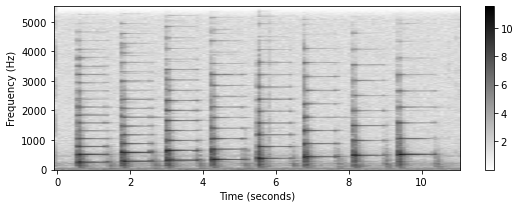

In [10]:
left = - (N / Fs) / 2
right = Y.shape[1] * H / Fs + (N / Fs) / 2
lower = - Fs / N
upper = Fs / 2 + Fs / N

print('Time range (seconds): [%5.2f, %5.2f]; frequency range (Hertz): [%5.2f, %5.2f]' 
      % (left, right, lower, upper))
      
plt.figure(figsize=(8, 3))
plt.imshow(np.log(1 + 1000 * Y), cmap='gray_r', aspect='auto', origin='lower', 
           extent=[left, right, lower, upper])
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
# plt.xlim([0, Y.shape[1] * H / Fs])
# plt.ylim([0, Fs / 2])
plt.colorbar()
plt.tight_layout()

Another alternative to plot a matrix is `matplotlib.pyplot.pcolormesh([h, v], I)`. This plotting function receives a 1-D array `h` to specify horizontal coordinates, a 1-D array `v` to specify vertical coordinates, as well as a 2-D array `I` containing the values for the image. When plotting `I[k, n]`, a quadrilateral is plotted having the left-lower corner `[h[n], v[k]]` and the right-upper corner `[h[n+1], v[k+1]]`. The dimensions of `h` and `v` should be one greater than those of `I`. 

Shapes of I, h, v:  (1025, 118) (119,) (1026,)


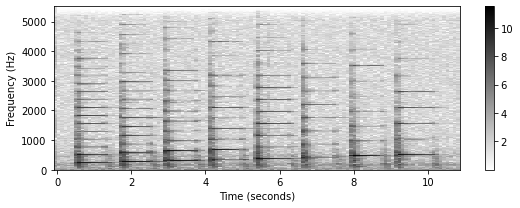

In [11]:
h = np.concatenate([t_frames, [t_frames[-1] + H / Fs]]) - ((N / Fs) / 2)
v = np.concatenate([f_hertz, [f_hertz[-1] + Fs / N]]) - (Fs / N / 2)
I = np.log(1 + 1000 * Y)

plt.figure(figsize=(8, 3))
plt.pcolormesh(h, v, I, cmap='gray_r')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.tight_layout()

print('Shapes of I, h, v: ', I.shape, h.shape, v.shape)

## Plotting a Chromagram

As a third example, we consider [chroma-based music features](../C3/C3S1_SpecLogFreq-Chromagram.html), which are an important representation in music processing. Assuming the equal-tempered scale, one considers the set

$$
\big\{\mathrm{C}, \mathrm{C}^\mathrm{\sharp}, \mathrm{D}, \mathrm{D}^\mathrm{\sharp}, \mathrm{E} ,\mathrm{F}, \mathrm{F}^\mathrm{\sharp}, \mathrm{G}, \mathrm{G}^\mathrm{\sharp}, \mathrm{A}, \mathrm{A}^\mathrm{\sharp}, \mathrm{B}\big\} 
$$

that consists of the twelve pitch spelling attributes (or chroma attributes) as used in Western music notation. Here, attributes such as $\mathrm{C}^\mathrm{\sharp}$ and $\mathrm{D}^\mathrm{\flat}$ are identified (enharmonic equivalence). The main idea of chroma features is to aggregate for a given local time window all information that relates to a given chroma into a single coefficient. Identifying pitches that differ by an octave (one therefore also speaks of **pitch classes**), chroma features show a high degree of robustness to variations in timbre and closely correlate to the musical aspect of harmony. As for audio signals, a time&ndash;chroma representation, also referred to as [**chromagram**](../C3/C3S1_SpecLogFreq-Chromagram.html), can be obtained from a spectrogram by suitably pooling frequency coefficients. For details, we refer to Section 3.1.2 of <a href="http://www.music-processing.de/">[Müller, FMP, Springer 2015]</a>.

In the following code cell, we compute such a chromagram from a spectrogam using `librosa`. Furthermore, the chromagram is visualized using the function `librosa.display.specshow`. 

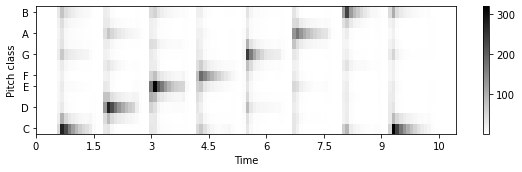

In [12]:
C = librosa.feature.chroma_stft(sr=Fs, S=Y, norm=None)

plt.figure(figsize=(8, 2.5))
librosa.display.specshow(C, y_axis='chroma', x_axis='time', sr=Fs, 
                         hop_length=H, cmap='gray_r')
plt.colorbar()
plt.tight_layout()

Again one can use the general function `matplotlib.pyplot.imshow`. 

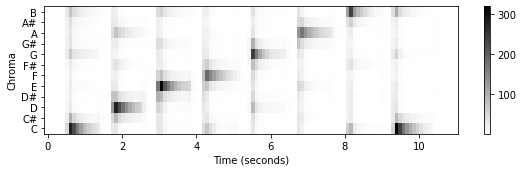

In [13]:
left = - (N / Fs) / 2
right = C.shape[1] * H / Fs + (N / Fs) / 2
bottom = - 0.5
top = 11.5

plt.figure(figsize=(8, 2.5))
plt.imshow(C, cmap='gray_r', aspect='auto', origin='lower', 
           extent=[left, right, bottom, top])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
plt.yticks(np.arange(12), 'C C# D D# E F F# G G# A A# B'.split())
plt.colorbar()
plt.tight_layout()

There are many ways to modify the appearance of the figure by tweaking parameters. We illustrate this in the next code cell. 

* First, we align the chroma tick labels to the left using the `ha` keyword argument of `matplotlib.pyplot.yticks`. 
* To avoid overlapping of ticks and axes, we then modify the properties of the vertical axis (`get_yaxis()`) using the parameter `pad`. Actually, there are numerous ways to set axis properties, see [`matplotlib.axes.Axes.axis`](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.axis.html). 
* Then we set the color limits of the current image using `clim`. Furthermore, we indicate how the appearance of the colorbar may be modified. 
* Finally, the application of 
[`tight_layout`](https://matplotlib.org/users/tight_layout_guide.html) automatically adjusts subplot parameters so that the subplots fit into the figure area.

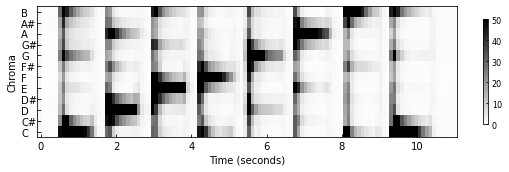

In [14]:
plt.figure(figsize=(8, 2.5))
plt.imshow(C, cmap='gray_r', aspect='auto', origin='lower', 
           extent=[left, right, bottom, top])
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
plt.yticks(np.arange(12), 'C C# D D# E F F# G G# A A# B'.split(), ha='left')

 # ha='left' leads to overlapping of ticks and plot. So we need some padding.
yax = plt.gca().get_yaxis() 
yax.set_tick_params(pad=16)
plt.tick_params(direction='in')
plt.clim((0, 50))
cbar = plt.colorbar(shrink=0.8)
cbar.ax.tick_params(labelsize=8) 
cbar.ax.tick_params(direction='in')
cbar.ax.tick_params(length=2)
plt.tight_layout()

As shown for the spectrogram above, one can also use `matplotlib.pyplot.pcolormesh` to obtain a similar visualization:

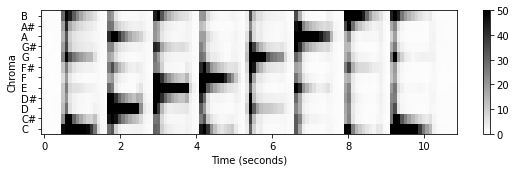

In [15]:
h = np.arange(C.shape[1] + 1) * H / Fs - ((N / Fs) / 2)
v = np.arange(13) - 0.5

plt.figure(figsize=(8, 2.5))
plt.pcolormesh(h, v, C, cmap='gray_r')
plt.xlabel('Time (seconds)')
plt.ylabel('Chroma')
plt.yticks(np.arange(12), 'C C# D D# E F F# G G# A A# B'.split(), ha='left')
yax = plt.gca().get_yaxis() 
yax.set_tick_params(pad=16)

plt.clim((0, 50))
plt.colorbar()
plt.tight_layout()

## Controlling the Colorbar

As the default, `imshow` shows the datapoints of a matrix as pixels which are visualized in a shape of a square (`aspect='equal'`). As a result, the overall proportion (aspect) of a subplot corresponds to the shape of the respective matrix to be plotted. This may lead to effects that are not wanted. For example, the colorbar plotted along with some matrix may have a different hight than the other plot. This can be adjusted by using the parameter ``aspect='auto'``, which adjusts the aspects so that the data fit in the axes. In general, this will result in non-square pixels. The effect is shown by the following example.

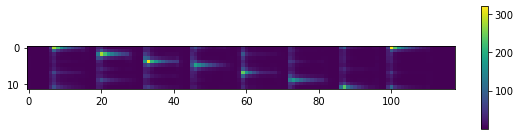

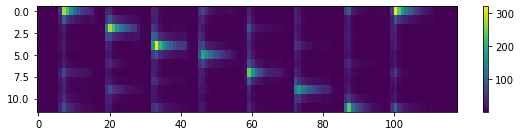

In [16]:
plt.figure(figsize=(8, 2))
plt.imshow(C, aspect='equal')
plt.colorbar()
plt.tight_layout()

plt.figure(figsize=(8, 2))
plt.imshow(C, aspect='auto')
plt.colorbar()
plt.tight_layout()

To better control the width of the colorbar, one can use the module `gridspec`, which allows for specifying the location of the subplots in a figure. For details, we refer to the website on [Customizing Figure Layouts Using GridSpec](https://matplotlib.org/users/gridspec.html).

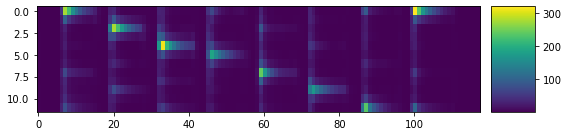

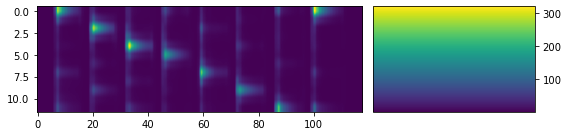

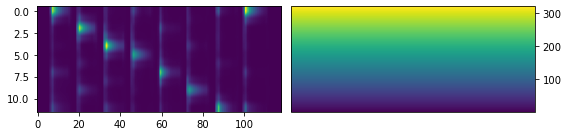

In [17]:
import matplotlib.gridspec as gridspec

for cwidth in [0.1, 0.5, 1]:
    
    plt.figure(figsize=(8, 2))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, cwidth])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    im = ax0.imshow(C, aspect='auto')
    plt.colorbar(im, cax=ax1)
    plt.tight_layout()    

Using the module `gridspec` allows for aligning plots that have elements with and without a colorbar. This is demonstrated by the following example, which uses the `gridspec`-constructor with keywords specified by the dictionary `gridspec_kw`. This dictionary, in turn, is one of the parameters of [`plt.subplots`](https://matplotlib.org/3.2.2/api/_as_gen/matplotlib.pyplot.subplots.html), which creates a figure and a set of subplots.

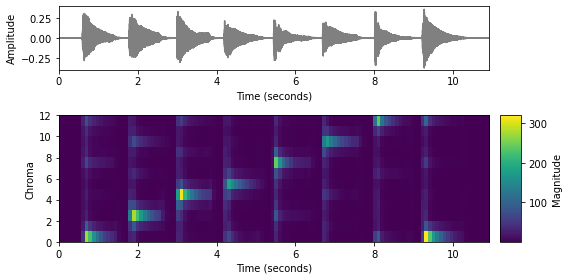

In [18]:
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.05], 
                                          'height_ratios': [1, 2]}, figsize=(8, 4))

im = ax[0, 0].plot(t, x, color='gray')
ax[0, 0].set_xlabel('Time (seconds)')
ax[0, 0].set_ylabel('Amplitude')
ax[0, 0].set_xlim([t[0], t[-1]])
ax[0, 0].set_ylim([-0.40, 0.40])
ax[0, 1].set_axis_off()

im = ax[1, 0].imshow(C, aspect='auto', origin='lower', extent=[t[0], t[-1], 0, 12])
plt.colorbar(im, cax=ax[1, 1])
ax[1, 0].set_xlabel('Time (seconds)')
ax[1, 0].set_ylabel('Chroma')
ax[1, 1].set_ylabel('Magnitude')

plt.tight_layout()

As already mentioned above, the command [`tight_layout`](https://matplotlib.org/users/tight_layout_guide.html) can be used to automatically adjust the spacing between subplots to minimize the overlaps. However, sometimes, the spacing in the final layout is not balanced (e.g., dominated by long labels or decorations that occur only in some of the subplots). As an alternative, the command [`constrained_layout`](https://matplotlib.org/3.1.1/tutorials/intermediate/constrainedlayout_guide.html) uses a constraint solver to determine a better size of axes that allows them to fit. The following figure illustrates the different behavior of the two functions. Note that, [according to the documentation](https://matplotlib.org/3.1.1/tutorials/intermediate/constrainedlayout_guide.html), the two functions are experimental features that may be removed without a deprecation period.

=== Without adjustment ===


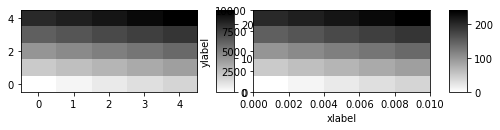

=== Adjustment with tight_layout ===


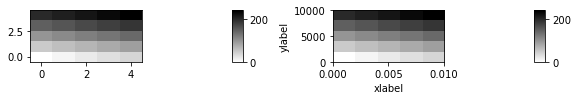

=== Adjustment with constrained_layout ===


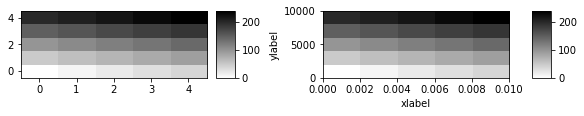

In [19]:
def plot_example(ax, matrix):    
    im1 = ax[0].imshow(matrix, aspect='auto', origin='lower', cmap='gray_r')
    plt.colorbar(im1, cax=ax[1])
    im2 = ax[2].imshow(matrix, aspect='auto', origin='lower', cmap='gray_r', extent=[0, 0.01, 0, 10000])
    ax[2].set_xlabel('xlabel')
    ax[2].set_ylabel('ylabel')
    plt.colorbar(im1, cax=ax[3])

matrix = np.arange(5*5).reshape(5, 5) * 10

print('=== Without adjustment ===')
fig, ax = plt.subplots(1, 4, figsize=(8, 1.5), gridspec_kw={'width_ratios': [1, 0.1, 1, 0.1]})
plot_example(ax, matrix)
plt.show()

print('=== Adjustment with tight_layout ===')
fig, ax = plt.subplots(1, 4, figsize=(8, 1.5), gridspec_kw={'width_ratios': [1, 0.1, 1, 0.1]})
plot_example(ax, matrix)
plt.tight_layout()
plt.show()

print('=== Adjustment with constrained_layout ===')
fig, ax = plt.subplots(1, 4, figsize=(8, 1.5), gridspec_kw={'width_ratios': [1, 0.1, 1, 0.1]}, 
                       constrained_layout=True)
plot_example(ax, matrix)
plt.show()

## Using and Defining Colormaps


When visualizing a feature representation, the enhancement of certain structures or properties can be crucial for conveying the message intended. One way, as we have seen before, is to modify the data by using a logarithmic scale (e.g., dB scale). Instead of modifying the data, an alternative is to use an appropriate colormap. For example, using a **logarithmically spaced color scheme** may help yielding a similar effect as applying logarithmic compression. Choosing a suitable colormap may help to accentuate certain values or to reduce the effect of outliers. We refer to the [overview for choosing a colormap](https://matplotlib.org/users/colormaps.html) for a discussion of further important criteria. The `matplotlib`-library not only offers a large number of [predifined colormaps](https://matplotlib.org/examples/color/colormaps_reference.html), but also allows for constructing customized colormaps. In the following, we give some examples using the following packages and functions:


* The class [`matplotlib.colors.LinearSegmentedColormap`](https://matplotlib.org/api/_as_gen/matplotlib.colors.LinearSegmentedColormap.html) allows for constructing colormaps based on lookup tables using linear segments.
* The method `LinearSegmentedColormap.from_list` from this class is helpful to construct a colormap from a list of colors.
* Valid color decriptors are listed on the page of the [matplotlib color api](https://matplotlib.org/api/colors_api.html).

In the third example, we demonstrate how to construct a colormap with logarithmic color distribution.

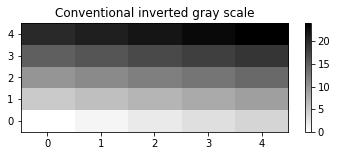

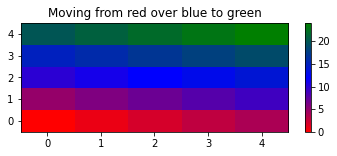

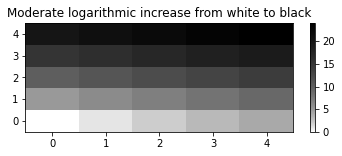

In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

matrix = np.arange(5 * 5).reshape(5, 5)

plt.figure(figsize=(6, 2))
plt.imshow(matrix, origin='lower', aspect='auto', cmap='gray_r')
plt.title('Conventional inverted gray scale')
plt.colorbar()

plt.figure(figsize=(6, 2))
color_rbg = LinearSegmentedColormap.from_list('color_rbg', ['r', 'b', 'g'], N=256)
plt.imshow(matrix, origin='lower', aspect='auto', cmap=color_rbg)
plt.title('Moving from red over blue to green')
plt.colorbar()

plt.figure(figsize=(6, 2))
gray_values = np.log(1 + 5 * np.linspace(0, 1, 256))
gray_values /= gray_values.max()
gray_values = 1 - gray_values
gray_values_rgb = np.repeat(gray_values.reshape(256, 1), 3, axis=1)
color_wb = LinearSegmentedColormap.from_list('color_wb', gray_values_rgb, N=256)
plt.imshow(matrix, origin='lower', aspect='auto', cmap=color_wb)
plt.title('Moderate logarithmic increase from white to black')
plt.colorbar();

## Using `FloatingBox`

Next, we introduce a method that allows for arranging arbitrary figures, which have been generated independently, next to each other. 
To this end, we provide the class `FloatingBox` which can be used to arrange several elements side by side by considering all elements as HTML inline div elements. For more information, we refer to the documentation about HTML [div tags](https://www.w3schools.com/tags/tag_div.ASP) and [inline elements](https://www.w3schools.com/html/html_blocks.asp).
The class `FloatingBox` is part of the Python package [libfmp](../B/B_libfmp.html). To use this class, one needs to add figures to a `FloatingBox` object. This procedure is illustrated by the example of the next code cell. 


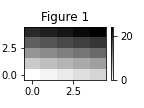
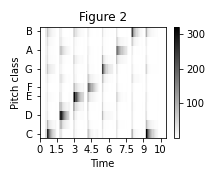
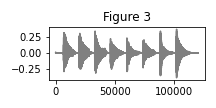

In [21]:
import sys
sys.path.append('..')
import libfmp.b
from libfmp.b import FloatingBox

float_box = libfmp.b.FloatingBox()

fig = plt.figure(figsize=(2, 1.5))
plt.imshow(matrix, origin='lower', aspect='auto', cmap='gray_r')
plt.title('Figure 1')
plt.colorbar()
plt.tight_layout()
float_box.add_fig(fig)

fig = plt.figure(figsize=(3, 2.5))
librosa.display.specshow(C, y_axis='chroma', x_axis='time', sr=Fs, 
                         hop_length=H, cmap='gray_r')
plt.colorbar()
plt.title('Figure 2')
plt.tight_layout()
float_box.add_fig(fig)

fig = plt.figure(figsize=(3, 1.5))
plt.plot(x, color='gray')
plt.title('Figure 3')
plt.tight_layout()
float_box.add_fig(fig)

float_box.show()

Besides figures generated by `matplotlib`, the class `FloatingBox` can also be used to arrange other HTML elements including tables and audio elements. This is demonstrated by the next example. 


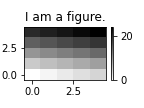

In [22]:
import pandas as pd
import IPython.display as ipd

float_box = libfmp.b.FloatingBox(align='top')

fig = plt.figure(figsize=(2, 1.5))
plt.imshow(matrix, origin='lower', aspect='auto', cmap='gray_r')
plt.title(r'I am a figure.')
plt.colorbar()
plt.tight_layout()
float_box.add_fig(fig)

float_box.add_html('<div>I am a <strong style="color: red;">custom</strong> HTML tag.</div>')

df = pd.DataFrame([['a'], ['b'], ['c']], columns=['I am a pandas table.'])
float_box.add_html(df.to_html())

audio = ipd.Audio(data=x[:1*Fs], rate=Fs)
float_box.add_html('<p style="text-align: center;">I am an audio tag.</p>' + audio._repr_html_())

float_box.show()

## Further Notes

Some of the visualization functions introduced above have been included into the [`libfmp`-library](../B/B_libfmp.html), which accompanies the FMP notebooks. These functions specify default setting as we typically use in our FMP notebooks. Other, more general visualization functions are provided by [LibROSA](https://librosa.org/doc). For a discussion of typical issues on `matplotlib`, we refer to the [FAQ website of `matplotlib`](https://matplotlib.org/faq/usage_faq.html). In the following code cell, we call some of our `libfmp`-functions:

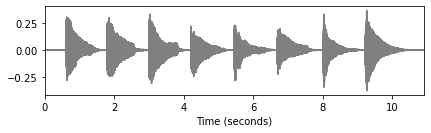

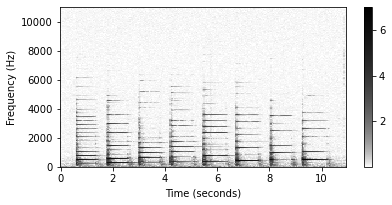

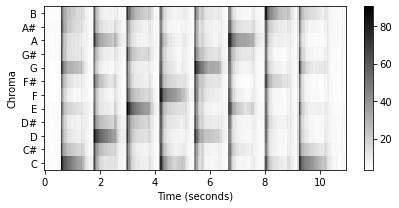

In [23]:
import sys
sys.path.append('..')
import libfmp.b

Fs = 22050
filename = os.path.join('..', 'data', 'B', 'FMP_B_Scale-Cmajor_Piano.wav')
x, Fs = libfmp.b.read_audio(filename)

libfmp.b.plot_signal(x, Fs)

N, H = 2048, 1024
X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hanning')
Y = np.abs(X)
Y = np.log(1 + 10 * Y)
cmap_compressed = libfmp.b.compressed_gray_cmap(alpha=10)
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, cmap=cmap_compressed)

C = librosa.feature.chroma_stft(sr=Fs, S=Y, norm=None)
libfmp.b.plot_chromagram(C, Fs=Fs/H);

For convenience, `libfmp` provides a class `MultiplePlotsWithColorbar` for the creation of plots in a two-column layout.
The axes of the first column can be used for different kinds of plots. The method `make_colorbars` automatically creates colorbars in the seconds column for image-based plots and hides the axes in other cases. The following example illustrates its usage:

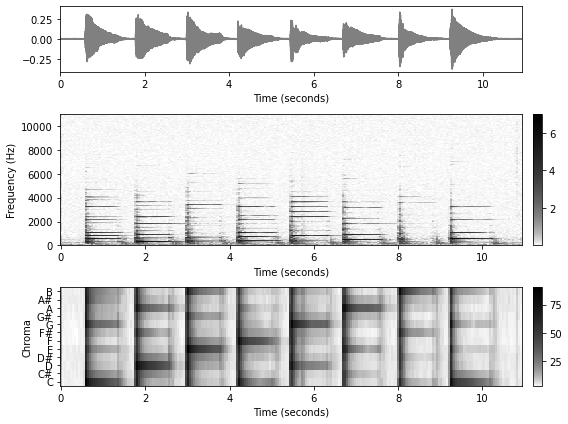

In [24]:
plot_with_colorbar = libfmp.b.MultiplePlotsWithColorbar(3, cbar_ratio=0.02, figsize=(8, 6),
                                                        height_ratios=[1, 2, 1.5])

libfmp.b.plot_signal(x, Fs, ax=plot_with_colorbar.axes[0])
libfmp.b.plot_matrix(Y, Fs=Fs/H, Fs_F=N/Fs, cmap=cmap_compressed, 
                     ax=[plot_with_colorbar.axes[1]], colorbar=False)
libfmp.b.plot_chromagram(C, Fs=Fs/H, cmap=cmap_compressed, 
                         ax=[plot_with_colorbar.axes[2]], colorbar=False)

plot_with_colorbar.make_colorbars()

<div class="alert" style="background-color:#F5F5F5; border-color:#C8C8C8">
<strong>Acknowledgment:</strong> This notebook was created by <a href="https://www.audiolabs-erlangen.de/fau/assistant/zalkow">Frank Zalkow</a> and <a href="https://www.audiolabs-erlangen.de/fau/professor/mueller">Meinard Müller</a>.
</div>

<table style="border:none">
<tr style="border:none">
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C0/C0.html"><img src="../data/C0_nav.png" style="height:50px" alt="C0"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C1/C1.html"><img src="../data/C1_nav.png" style="height:50px" alt="C1"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C2/C2.html"><img src="../data/C2_nav.png" style="height:50px" alt="C2"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C3/C3.html"><img src="../data/C3_nav.png" style="height:50px" alt="C3"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C4/C4.html"><img src="../data/C4_nav.png" style="height:50px" alt="C4"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C5/C5.html"><img src="../data/C5_nav.png" style="height:50px" alt="C5"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C6/C6.html"><img src="../data/C6_nav.png" style="height:50px" alt="C6"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C7/C7.html"><img src="../data/C7_nav.png" style="height:50px" alt="C7"></a></td>
    <td style="min-width:50px; border:none" bgcolor="white"><a href="../C8/C8.html"><img src="../data/C8_nav.png" style="height:50px" alt="C8"></a></td>
</tr>
</table>